# Modelo epidemiológico SIR en redes complejas

Este notebook explora los efectos de la topología de una red en el modelo epidemiológico Susceptible-Infectado-Recuperado (SIR).

La exposición a la infección se da entre vecinos de la red. Nodos susceptibles se infectan con una probabilidad dada, si son expuestos. Nodos infectados se recuperan con cierta probabilidad, o mueren al cabo de la duración de la infección.

In [1]:
import networkx as nx
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import networkx as nx

## Nodos de la red son objetos clase *Agente*

La simulación es basada en agentes, a continuación se define la clase de Python a partir de la cuál se crearán.

In [2]:
S = 'susceptible'
I = 'infectado'
R = 'recuperado'
M = 'muerto'


class Agente:
    """
    Agentes de la simulación. Su estado puede ser S, I o R.
    Por default se crean en estado S.
    La variable interna tiempo_infectado controla cuánto tiempo
    está enfermo un agente infectado, al cabo del cuál si no se
    recuperan adoptan el estado M, o sea, muertos y son eliminados
    de la red.
    """
    def __init__(self, estado=S):
        self.tiempo_infectado = 0
        self.estado = estado
            
    def actualiza_estado(self):
        if self.estado == I:
            if self.tiempo_infectado < duracion_infeccion:
                # en cualquier momento durante su enfermedad pueden recuperarse
                if random.random() <= probabilidad_recuperacion:
                    self.estado = R
                else:
                    # si no se recuperan, pasan más tiempo enfermos
                    self.tiempo_infectado += 1
            else:
                # si no se recuperan durante su enfermedad, mueren
                self.estado = M

## Dinámica en la red

La función **time_step** definida a continuación toma una red en el tiempo $t$ y devuelve su estado en el tiempo $t+1$. Esta función se encarga de:
 - exponer a los vecinos de los nodos infectados
 - actualizar el estado de todos los nodos invocando el método **actualiza_estado()**
 - quitar de la red a los agentes muertos

In [3]:
def time_step(H):
    g = copy.deepcopy(H)

    # lista de infectados
    nodos_i = [n for n in g.nodes 
               if g.nodes[n]['agente'].estado == I]

    # infectados probablemente contagian a sus vecinos
    for n in nodos_i:
        for exposed in g.neighbors(n):
            if (random.random() <= probabilidad_infeccion
                and
                g.nodes[exposed]['agente'].estado == S):
                g.nodes[exposed]['agente'].estado = I
                
    # actualiza estado de nodos
    for n in g.nodes():
        g.nodes[n]['agente'].actualiza_estado()
    
    # quitar muertos
    nodos_muertos = [n for n in g.nodes 
                     if g.nodes[n]['agente'].estado == M]
    for n in nodos_muertos:
        g.remove_node(n)

    return g

## Para graficar tamaños de subpoblaciones

In [4]:
def plot_pop_sir(t):
    """
    t es una lista de redes, una para cada punto en el tiempo
    """
    count_s = []; count_i = []; count_r = []

    for h in t:
        count_s.append(len([n for n in h.nodes
                            if h.nodes[n]['agente'].estado == S]))
        count_i.append(len([n for n in h.nodes
                            if h.nodes[n]['agente'].estado == I]))
        count_r.append(len([n for n in h.nodes
                            if h.nodes[n]['agente'].estado == R]))                     
                       
    plt.plot(range(len(t)), count_s, color='teal')
    plt.plot(range(len(t)), count_i, color='orange')
    plt.plot(range(len(t)), count_r, color='purple')  

## Para graficar la red al paso del tiempo

In [5]:
def plot_nw_sir(t):
    pos=nx.spring_layout(t[0])
    plt.figure(1, dpi=160)
    for i in range(12):
        g = t[i]
        nodos_s = [n for n in g.nodes 
                   if g.nodes[n]['agente'].estado == S]
        nodos_i = [n for n in g.nodes 
                   if g.nodes[n]['agente'].estado == I]
        nodos_r = [n for n in g.nodes 
                   if g.nodes[n]['agente'].estado == R]
        ax = plt.subplot(4, 3, i+1)
        ax.set_axis_off()
        ax.set_title("$t=%s$" % i, fontsize=6, y=0.92)
        plt.xticks([]), plt.yticks([])
        nx.draw_networkx_nodes(g, pos,
                               nodelist=nodos_i,
                               node_color='orange',
                               node_size=23,
                               alpha=1)
        nx.draw_networkx_nodes(g, pos,
                               nodelist=nodos_s,
                               node_color='teal',
                               node_size=30,
                               alpha=0.3)
        nx.draw_networkx_nodes(g, pos,
                               nodelist=nodos_r,
                               node_color='purple',
                               node_size=30,
                               alpha=0.3)
        nx.draw_networkx_edges(g, pos, width=1.0, alpha=0.1)

## Topología Erdős-Rényi

In [6]:
# creamos la red con la topología deseada a través de la biblioteca NetworkX
G = nx.erdos_renyi_graph(100, 0.11)

# ponemos un agente en cada nodo, todos en estado S
for n in G.nodes():
    G.nodes[n]['agente'] = Agente(estado=S)

# infectemos uno sólo
n = random.choice(list(G.nodes))
G.nodes[n]['agente'].estado = I

duracion_infeccion = 5
probabilidad_infeccion = 0.66
probabilidad_recuperacion = 0.32

iteraciones = 12

# la red original en el primer tiempo
t = [G, ]
for i in range(1, iteraciones):
    t.append(time_step(t[i-1]))

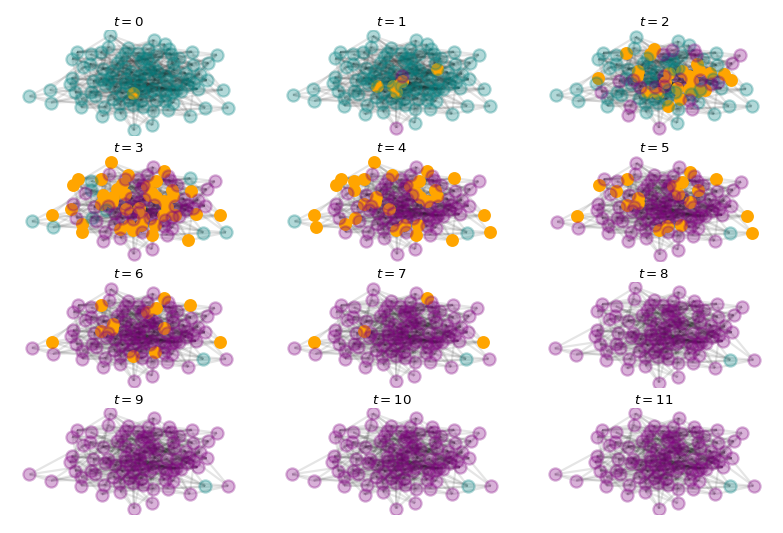

In [7]:
plot_nw_sir(t)

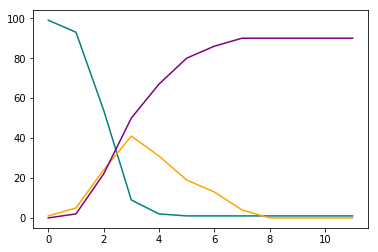

In [8]:
plot_pop_sir(t)

## Topología Exponencial

In [9]:
# creamos la red con la topología deseada a través de la biblioteca NetworkX
G = nx.random_graphs.gnm_random_graph(100, 350)

# ponemos un agente en cada nodo, todos en estado S
for n in G.nodes():
    G.nodes[n]['agente'] = Agente(estado=S)

# infectemos uno sólo
n = random.choice(list(G.nodes))
G.nodes[n]['agente'].estado = I

duracion_infeccion = 2
probabilidad_infeccion = 0.5
probabilidad_recuperacion = 0.4

iteraciones = 12

# la red original en el primer tiempo
t = [G, ]
for i in range(1, iteraciones):
    t.append(time_step(t[i-1]))

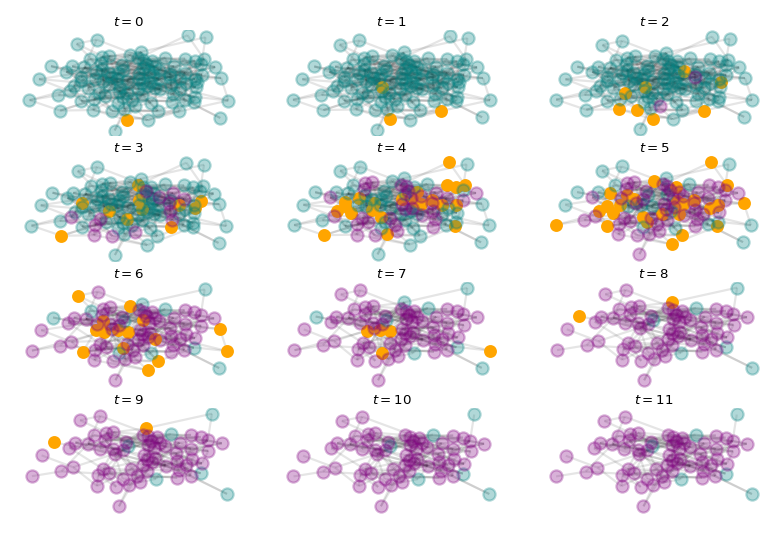

In [10]:
plot_nw_sir(t)

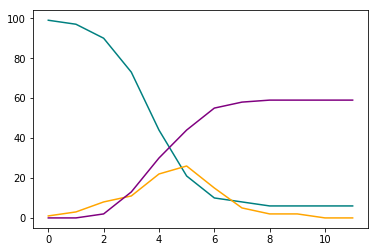

In [11]:
plot_pop_sir(t)

## Topología Barabasi-Albert

In [12]:
# creamos la red con la topología deseada a través de la biblioteca NetworkX
G = nx.random_graphs.barabasi_albert_graph(100, 10)

# ponemos un agente en cada nodo, todos en estado S
for n in G.nodes():
    G.nodes[n]['agente'] = Agente(estado=S)

# infectemos uno sólo
n = random.choice(list(G.nodes))
G.nodes[n]['agente'].estado = I

duracion_infeccion = 4
probabilidad_infeccion = 0.5
probabilidad_recuperacion = 0.3

iteraciones = 12

# la red original en el primer tiempo
t = [G, ]
for i in range(1, iteraciones):
    t.append(time_step(t[i-1]))

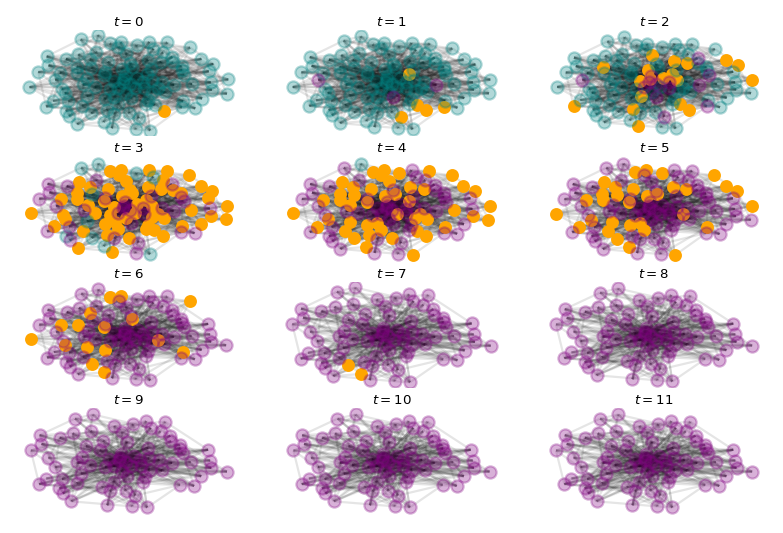

In [13]:
plot_nw_sir(t)

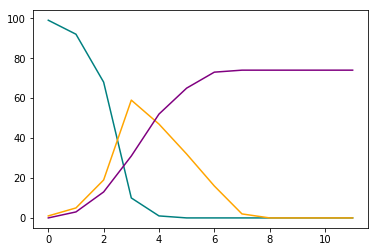

In [14]:
plot_pop_sir(t)

## Topología Watts-Strogatz

In [15]:
# creamos la red con la topología deseada a través de la biblioteca NetworkX
G = nx.random_graphs.watts_strogatz_graph(100, 5, 0.3)

# ponemos un agente en cada nodo, todos en estado S
for n in G.nodes():
    G.nodes[n]['agente'] = Agente(estado=S)

# infectemos uno sólo
n = random.choice(list(G.nodes))
G.nodes[n]['agente'].estado = I

duracion_infeccion = 4
probabilidad_infeccion = 0.5
probabilidad_recuperacion = 0.3

iteraciones = 12

# la red original en el primer tiempo
t = [G, ]
for i in range(1, iteraciones):
    t.append(time_step(t[i-1]))

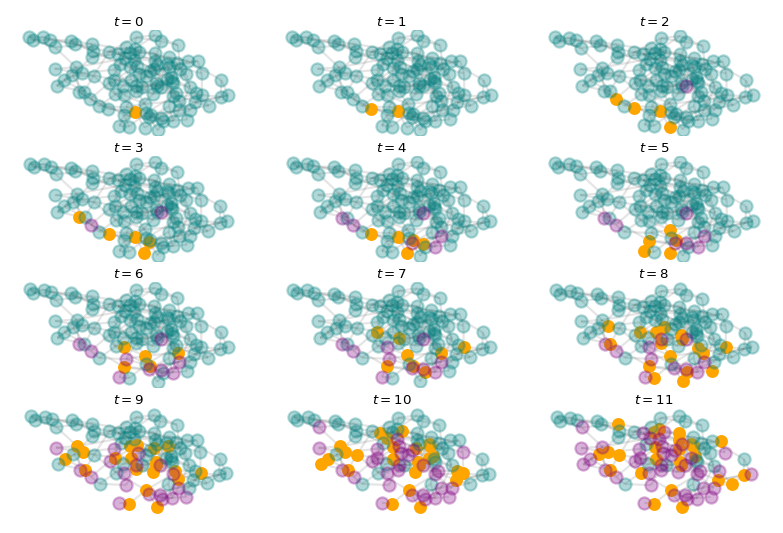

In [16]:
plot_nw_sir(t)

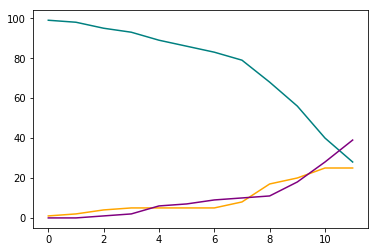

In [17]:
plot_pop_sir(t)